## Notes:
- In Chapter2, we used supervised machine learning. Here, we used unsupervised ML Techniques for fraud detection.
- Moreover, fraud patterns change over time, so supervised systems that are built using fraud labels become stale, capturing historical patterns of fraud but failing to adapt to newly emerging patterns.
- For these reasons (the lack of sufficient labels and the need to adapt to newly emerging patterns of fraud as quickly as possible), unsupervised learning shines.

**We'll be using the same dataset**

# 1. Import the necessary libraries

In [1]:
# Main
import os
import numpy as np
import pandas as pd

pd.set_option("display.max_columns", 50)

# Data Visualization
import seaborn as sns
color = sns.color_palette()

import matplotlib.pyplot as plt
plt.style.use('seaborn')

# Data-Preparation
from scipy import stats
from sklearn import metrics
from sklearn import preprocessing
from sklearn import model_selection

# ML-Algorithms
import lightgbm as lgb
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

print("Libraries imported!")

Libraries imported!


# 2. Load the data

In [2]:
credit_data = pd.read_csv("../Ch-2/input/creditcard.csv.gz")
print(f"The Dataset has {credit_data.shape[0]} rows and {credit_data.shape[1]} columns")
display(credit_data.head())

The Dataset has 284807 rows and 31 columns


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# 3. Data preparation

In [3]:
credit_dataX = credit_data.copy().drop(["Class"], axis=1)
credit_dataY = credit_data["Class"].copy()

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(credit_dataX,
                                                                    credit_dataY,
                                                                    random_state=2018,
                                                                    shuffle=True,
                                                                    test_size=0.33,
                                                                    stratify=credit_dataY)

print(f"TRAINING INFO: {X_train.shape} {y_train.shape}")
print(f"TEST INFO: {X_test.shape} {y_test.shape}")

TRAINING INFO: (190820, 30) (190820,)
TEST INFO: (93987, 30) (93987,)


In [5]:
featuresToScale = X_train.columns
print(featuresToScale, len(featuresToScale))  # Class and Time removed

## Standardization
std_scl = preprocessing.StandardScaler(copy=True)
X_train.loc[:, featuresToScale] = std_scl.fit_transform(X_train)
X_test.loc[:, featuresToScale] = std_scl.transform(X_test)
print("Standardization completed...")

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object') 30
Standardization completed...


# 4. Evaluating 
## 4.1 Define Anomaly Score Function
- Assuming that fraud is rare and looks somewhat different than the majority of transactions.
- Those that occur the least often and are the most anomalous. 
- Since fraud is rare and presumably different than normal transactions, the fraudulent transactions should exhibit the largest reconstruction error. 

**So let’s define the anomaly score as the reconstruction error.**

In [6]:
def anomaly_score(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF) - np.array(reducedDF))**2, axis=1)  # row-wise subtraction and then col-wise addition
    loss = pd.Series(data=loss, index=originalDF.index)
    loss = (loss - np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

## 4.2 Define Evaluation Metrics
- Since we're building unsupervised learning. The labels will help us understand
just how well these solutions are at catching known patterns of fraud.

In [7]:
def plot_results(trueLabels, anomalyScores, model_instance=None, returnPreds=False): # array, array, bool
    
    preds_df=pd.concat([trueLabels, anomalyScores], axis=1)
    preds_df.columns = ["trueLabel", "anomalyScore"]
    
    # calcluate precision, recall
    precision, recall, thresholds = metrics.precision_recall_curve(preds_df["trueLabel"], preds_df["anomalyScore"])
    
    # calculate average_precision_score
    avg_precision_score = metrics.average_precision_score(preds_df["trueLabel"], preds_df["anomalyScore"])
    
    # Plotting Precision Recall Curve
    plt.figure(figsize=(8, 6), tight_layout=True)
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='k', label=model_instance.__class__.__name__)
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.xlabel('Recall', size=14)
    plt.ylabel('Precision', size=14)
    plt.legend(loc="upper right", fontsize=14)
    plt.title(f"Precision-Recall Curve: Average Precision = {avg_precision_score:.2f}", fontsize=18)
    
    # Plotting ROC-AUC Curve
    fpr, tpr, thresh = metrics.roc_curve(preds_df["trueLabel"], preds_df["anomalyScore"])
    # calculate roc-auc score
    auc_score = metrics.auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6), tight_layout=True)
    # Plot the diagonal 50% line
    plt.plot([0, 1], [0, 1], 'k--')
    # Plot the FPR and TPR achieved by our model
    plt.plot(fpr, tpr, label=f"{model_instance.__class__.__name__ }(AUC={auc_score:.3f})", marker=".")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: Area under the curve = {0:0.2f}'.format(auc_score), fontsize=18)
    plt.legend(loc="lower right", fontsize=14)
    plt.show()
    
    if returnPreds==True:
        return preds_df, avg_precision_score

## 4.3 Define plotting function

In [8]:
def scatter_plot(x_pca, true_label, algoName=None):
    # fetch the first-two principal components of pca
    first_two_vecs = x_pca.iloc[:, 0:2]
    tempDF = pd.concat([first_two_vecs, true_label], axis=1)
    tempDF.columns = ["First Vector", "Second Vector", "Labels"]
    
    sns.lmplot(data=tempDF,
               x="First Vector",
               y="Second Vector",
               hue="Labels",
               fit_reg=False,
               height=5,
               aspect=1.5
               )
    plt.title("Separation of Observation using:"+algoName)
    plt.show()

## 5. Normal PCA Anomaly Detection
- Features in the above credit card transactions dataset are generated from  PCA.
- However, there is nothing unusual to perform PCA on an already dimensionality-reduced dataset for anomaly detection.

## Approach to be followed:
- First, We try to find the optimal principal components which helps to identify underlying patterns of the data.
- Then, we create original df using the transformed pca_df.
- Finally, calculate the anomaly b/w these two dfs. 

## 5.1 With n_components = features
- When the number of principal components equals the number of original dimensions, PCA captures nearly 100% of the variance/information in the data.
- Therefore, when PCA reconstructs the transactions from the principal components (reverse_transformation), it will have too little reconstruction error for all the transactions, fraudulent or otherwise.
- We'll check this by evaluating metrics.

**To get the better understanding, Let's apply PCA and generate the same number of principal components as the number of original features**

In [9]:
from sklearn.decomposition import PCA

# n_components: int, default=min(n_samples, features)
# whiten : bool, default=False
    #  When True:  the components_ vectors are multiplied by the square root of n_samples 
    #  and then divided by the singular values to ensure uncorrelated outputs with unit component-wise variances.
    
    # Whitening will remove some information from the transformed signal (the relative variance scales of the components) 
    # but can sometime improve the predictive accuracy of the downstream estimators by making their data respect 
    # some hard-wired assumptions.
    
n_components = X_train.shape[1]  # 30 features
whitten = False
random_state = 2018

pca = PCA(n_components=n_components,
          whiten=whitten,
          random_state=random_state)

pca

PCA(n_components=30, random_state=2018)

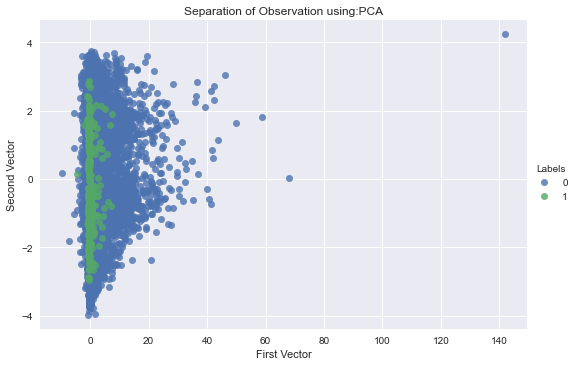

In [10]:
X_train_pca = pca.fit_transform(X_train)
X_train_pca_inverse = pca.inverse_transform(X_train_pca)

X_train_pca = pd.DataFrame(X_train_pca, index=X_train.index)
X_train_pca_inverse = pd.DataFrame(X_train_pca_inverse, index=X_train.index)

scatter_plot(X_train_pca, y_train, "PCA")

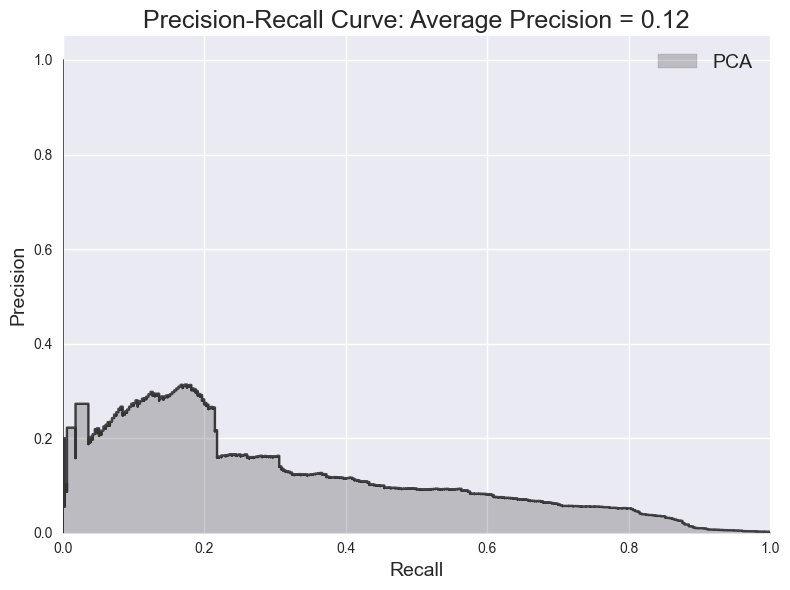

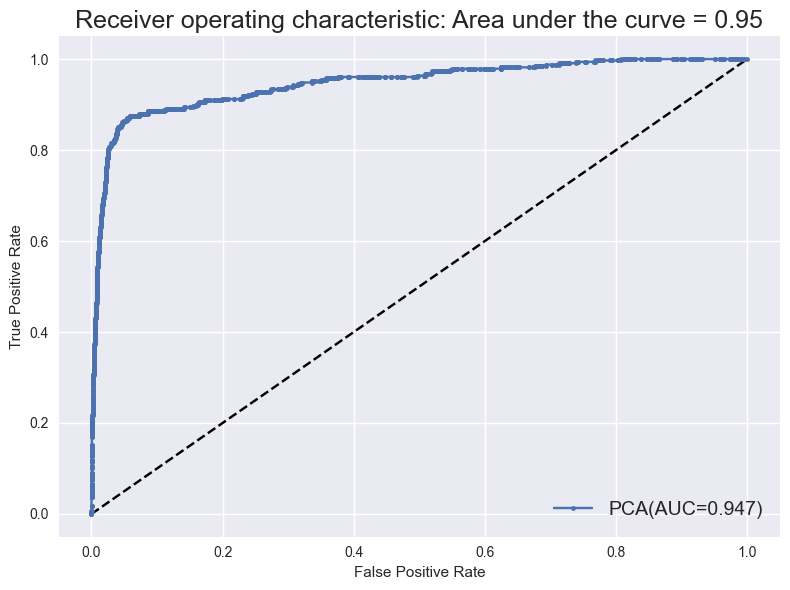

In [11]:
anomalyScoresPCA = anomaly_score(X_train_pca, X_train_pca_inverse)
predsPCA, avg_pr_score = plot_results(y_train, anomalyScoresPCA, model_instance=pca, returnPreds=True)

### Conclusion :
- With an average precision of 0.18, this is a poor fraud detection solution

----
## 5.2 Determining optimal n_components

In [12]:
def determine_optimal_n_value(y_train, n_components_start=2, n_components_end=29, random_state=2018):
    avg_precision_scores = {}
    
    for idx, n_components in enumerate(range(n_components_start, n_components_end), start=3):
        pca = PCA(n_components=n_components,
                  whiten=True,
                  random_state=random_state)
        
        X_train_iter_pca = pca.fit_transform(X_train)
        X_train_iter_pca_reverse = pca.inverse_transform(X_train_iter_pca)
        
        X_train_iter_pca = pd.DataFrame(data=X_train_iter_pca, index=X_train.index)
        X_train_iter_pca_reverse = pd.DataFrame(data=X_train_iter_pca_reverse, index=X_train.index)
                
        anomalyScoresIterPCA = anomaly_score(X_train, X_train_iter_pca_reverse) # orginalDF, reducedDF
        
        predsIter = pd.concat([y_train, anomalyScoresIterPCA], axis=1)
        predsIter.columns = ["TrueLabel", "AnomalyScore"]
        
        avg_pr_score = metrics.average_precision_score(predsIter["TrueLabel"], predsIter["AnomalyScore"])
        avg_precision_scores[n_components] = round(avg_pr_score, 3)
        
    return avg_precision_scores

avg_precision_scores = determine_optimal_n_value(y_train)
print(avg_precision_scores)

{2: 0.167, 3: 0.177, 4: 0.19, 5: 0.193, 6: 0.206, 7: 0.188, 8: 0.202, 9: 0.222, 10: 0.233, 11: 0.252, 12: 0.251, 13: 0.279, 14: 0.272, 15: 0.272, 16: 0.295, 17: 0.292, 18: 0.299, 19: 0.303, 20: 0.306, 21: 0.316, 22: 0.319, 23: 0.331, 24: 0.349, 25: 0.45, 26: 0.546, 27: 0.691, 28: 0.003}


In [13]:
# The best n_components:
max(avg_precision_scores.items(), key=lambda v: v[1])  

(27, 0.691)

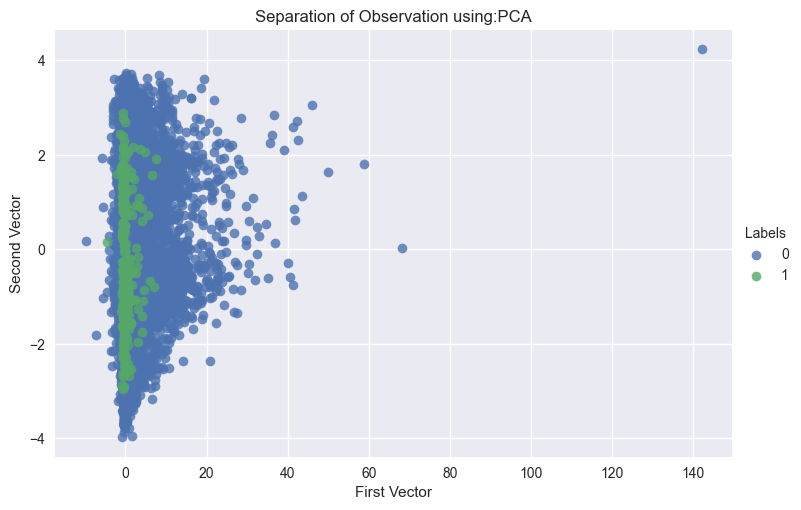

In [14]:
# 27 principal components
from sklearn.decomposition import PCA

n_components = 27
whiten = False
random_state = 2018

pca = PCA(n_components=n_components, whiten=whiten, random_state=random_state)

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=X_train.index)

X_train_PCA_inverse = pca.inverse_transform(X_train_PCA)
X_train_PCA_inverse = pd.DataFrame(data=X_train_PCA_inverse, index=X_train.index)

scatter_plot(X_train_PCA, y_train, "PCA")

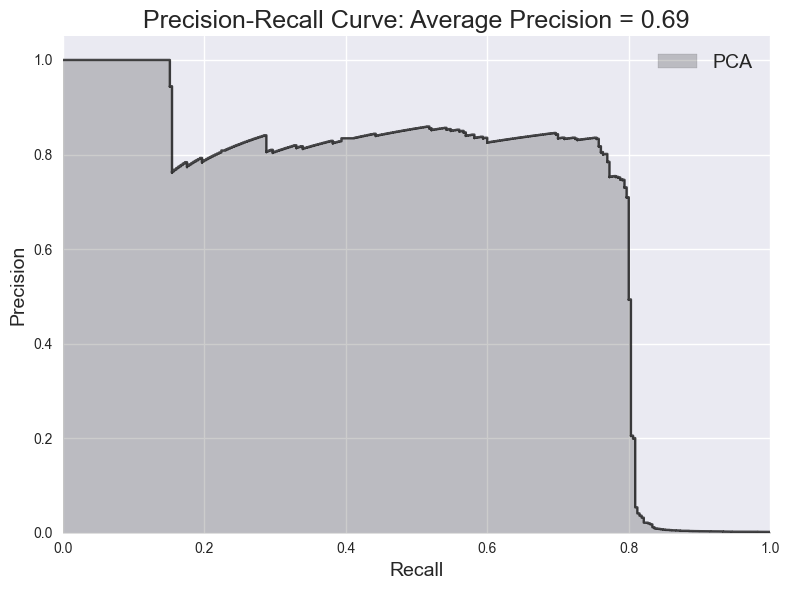

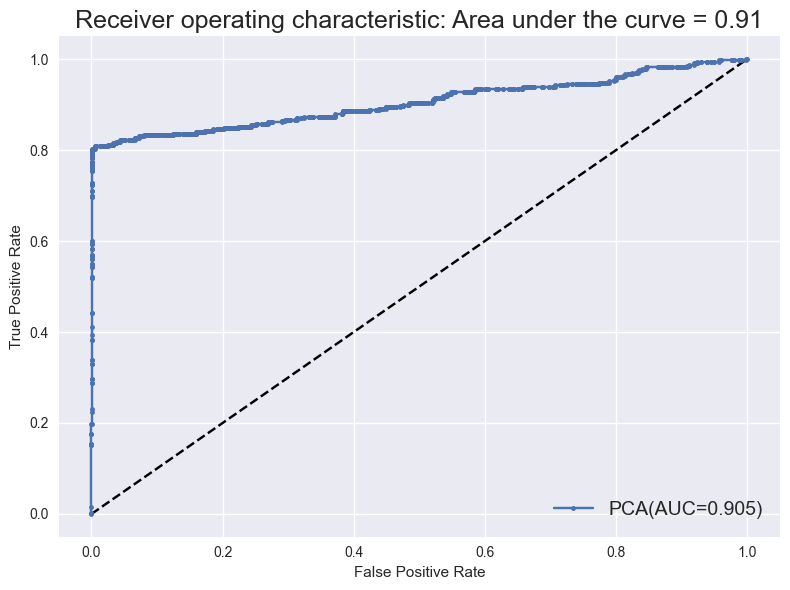

In [15]:
# View plot
anomalyScoresPCA = anomaly_score(X_train, X_train_PCA_inverse)
preds, avg_pr_score = plot_results(y_train, anomalyScoresPCA, pca, True)

### Conclusion:
- With n_components=27, we get Average Precision Score = 0.69
- Using `y_train.value_counts()`; we can see there are only 330 frauds transcation out of total 190,820 transcations (190490 + 300).
- Using PCA, we calcualte the anomalyScore for these 190,820 transcation.

**Let's sort w.r.t to anomalyScore (datapoints with high error high PE of fraud transcations) and fetch top 350 datapoints and calculate Precision and Recall**

In [46]:
preds.sort_values(by="anomalyScore", ascending=False, inplace=True)
cutOff = 350  # Resoning here is, anomaly_score would be high for these datapoints (means fraud transcations)

predsTop = preds[:cutOff]
display(predsTop.head())

,trueLabel,anomalyScore
154684,1,1.000000
151006,1,0.901799
151008,1,0.901799
151007,1,0.901799
151009,1,0.901799


```
Precision and Recall for Top 350 transcations
**1.Precision = TP/(TP+FP)**
**2.Recall = TP/(TP+FN)**
```

In [43]:
y_train.value_counts() # TP=330, TN = 190490

0    190490
1       330
Name: Class, dtype: int64

In [29]:
predsTop.trueLabel.value_counts()   # Out of 330, with PCA able to predict 261 currently (after sorting the anomalyScore)

1    261
0     89
Name: trueLabel, dtype: int64

In [47]:
correctPredictionByPCA = predsTop.anomalyScore[predsTop.trueLabel ==1].count() # No of 1s detected by the PCA wrt to anomalyScore
print(correctPredictionByPCA)

print(f"Precision: {np.round(correctPredictionByPCA/cutOff, 2)}")  #  percenatge of corrent prediction out of total predictions made
print(f"Recall: {np.round(correctPredictionByPCA/y_train.sum(), 2)}") # percenatge of corrent prediction out of `actual predictions`

print(f"Fraud Caught out of {y_train.sum()} Cases:", predsTop.trueLabel.sum())

261
Precision: 0.75
Recall: 0.79
Fraud Caught out of 330 Cases: 261


# 2. Sparse PCA Anomaly Detection